In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

def segment_and_crop_images(image_paths, model, show_images=False):
    # Run batched inference on a list of images
    results = model(image_paths)  # return a list of Results objects
    cropped_images = []

    # Process results list
    for img_path, result in zip(image_paths, results):
        image = cv2.imread(img_path)
        boxes = result.boxes  # Boxes object for bounding box outputs
        masks = result.masks  # Masks object for instance segmentation masks
        class_names = result.names  # Class names for the detected objects
        
        if masks is not None:
            for idx, (box, mask) in enumerate(zip(boxes, masks)):
                
                # Get the predicted class name
                class_id = int(box.cls[0])
                class_name = class_names[class_id]

                # Skip if the class is not a person
                if class_name != 'person':
                    print(f"Skipping box {idx+1} as it is not a person.")
                    continue
                
                # Get coordinates of the bounding box
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                
                # Convert mask to NumPy array and get the mask coordinates
                mask_np = mask.data.squeeze(0).cpu().numpy()
                mask_coords = mask.xy[0]
                
                # Create a blank mask with the same dimensions as the original image
                blank_mask = np.zeros(image.shape[:2], dtype=np.uint8)
                
                # Fill the blank mask with the mask coordinates
                cv2.fillPoly(blank_mask, [mask_coords.astype(np.int32)], 1)
                
                # Apply the mask to the original image
                masked_image = cv2.bitwise_and(image, image, mask=blank_mask)
                
                # Crop the masked image using the bounding box coordinates
                cropped_masked_img = masked_image[y1:y2, x1:x2]
                cropped_images.append(cropped_masked_img)
                
                if show_images:
                    # Get the predicted class name
                    class_id = int(box.cls[0])
                    class_name = class_names[class_id]
                    
                    # Display the masked cropped image with the class name in the title
                    plt.imshow(cv2.cvtColor(cropped_masked_img, cv2.COLOR_BGR2RGB))
                    plt.title(f'Masked Cropped Box {idx+1} - Class: {class_name}')
                    plt.axis('off')
                    plt.show()
        else:
            print("No masks detected.")
    
    return cropped_images


0: 640x640 12 persons, 1157.5ms
1: 640x640 5 persons, 2 handbags, 1 chair, 1157.5ms
2: 640x640 4 persons, 1 backpack, 1 tie, 1 skateboard, 1157.5ms
3: 640x640 1 person, 1157.5ms
Speed: 3.7ms preprocess, 1157.5ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 640)


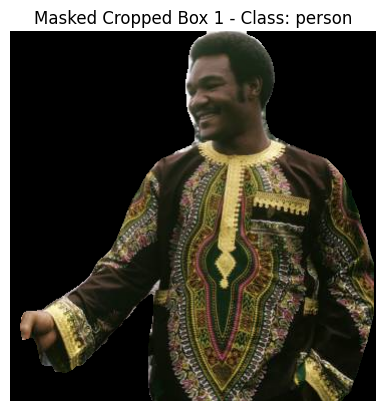

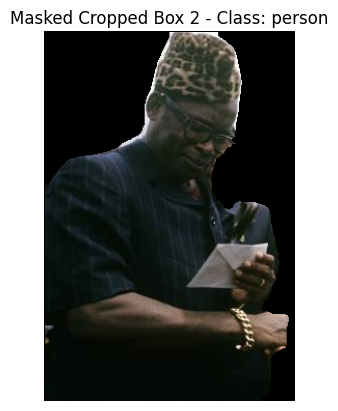

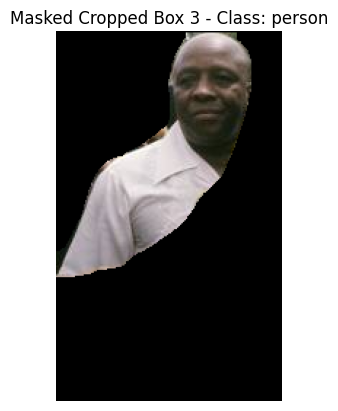

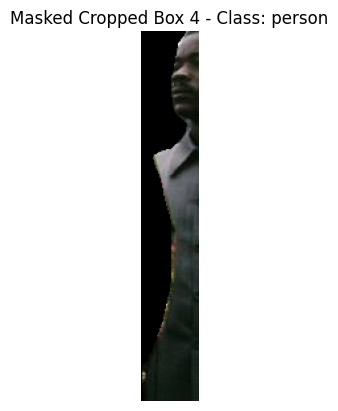

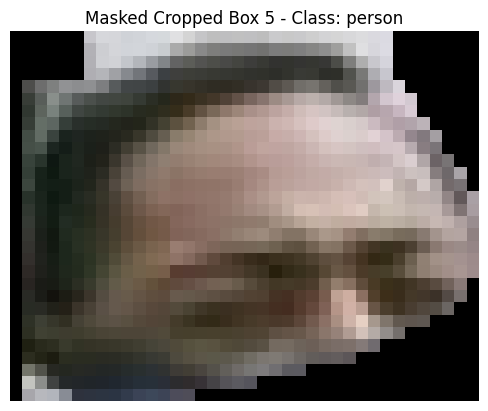

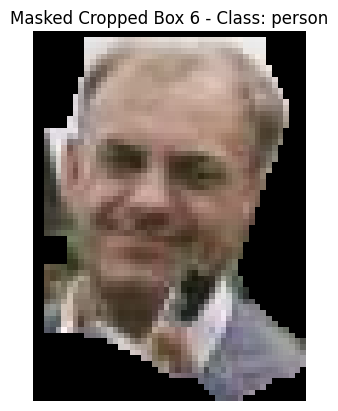

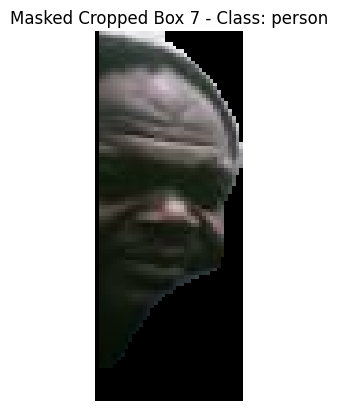

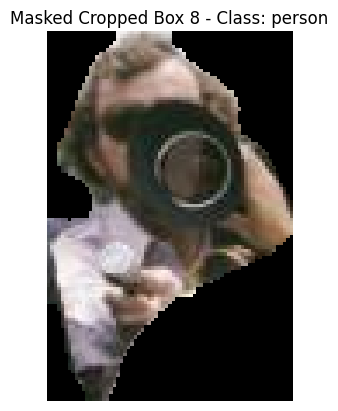

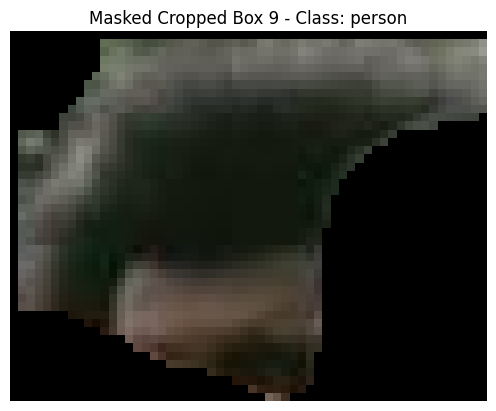

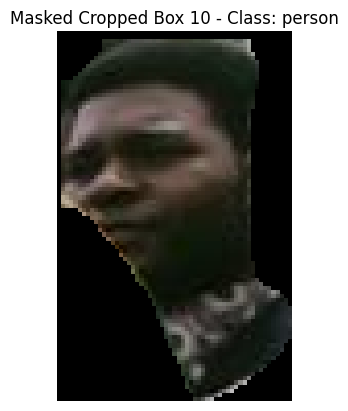

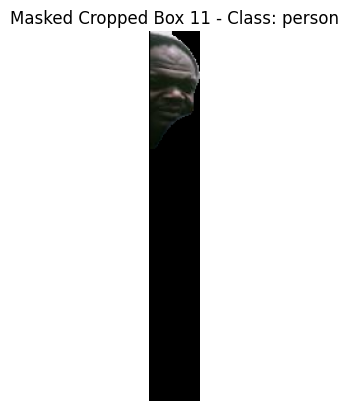

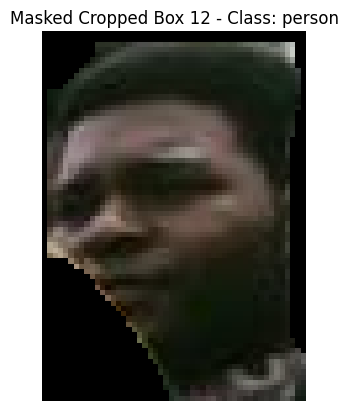

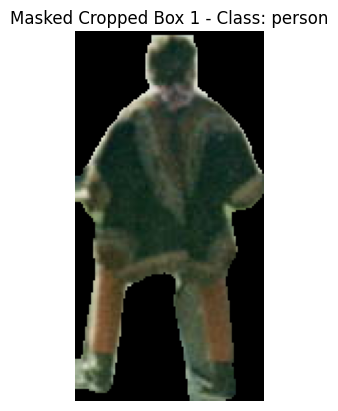

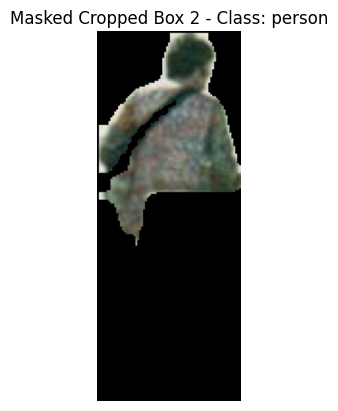

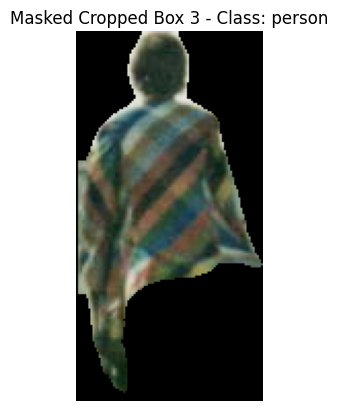

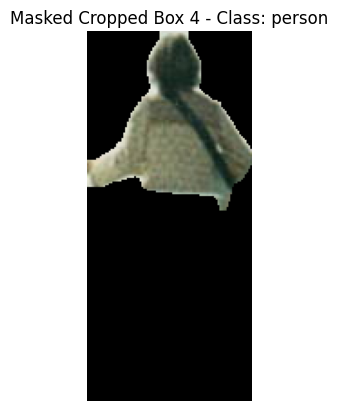

Skipping box 5 as it is not a person.
Skipping box 6 as it is not a person.
Skipping box 7 as it is not a person.


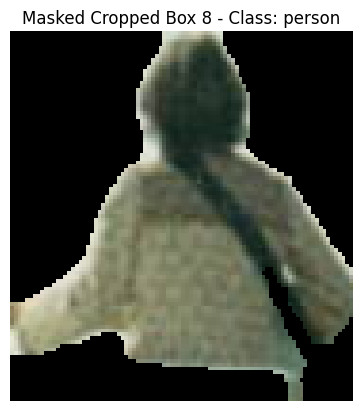

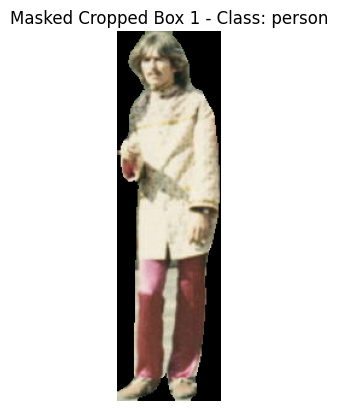

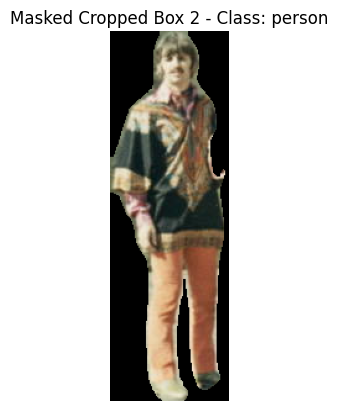

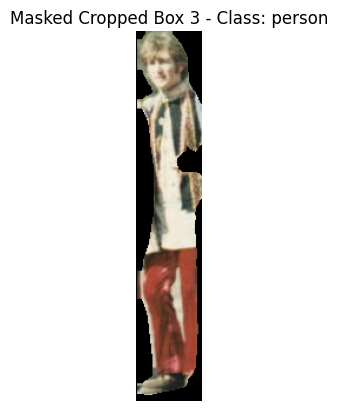

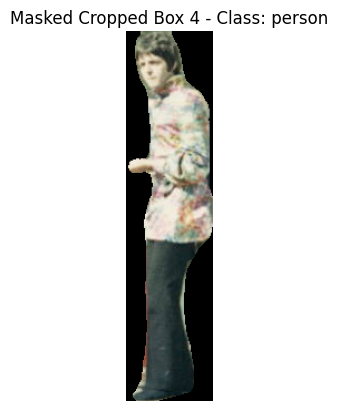

Skipping box 5 as it is not a person.
Skipping box 6 as it is not a person.
Skipping box 7 as it is not a person.


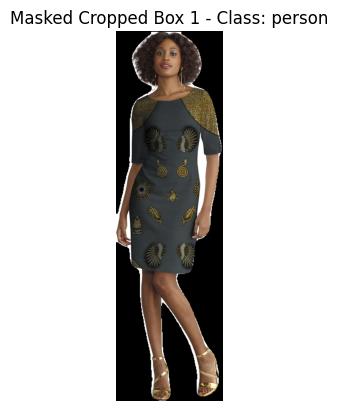

In [6]:
# Example usage:
model = YOLO("yolov8l-seg.pt")
image_paths = ["../data/X.jpg", "../data/Y.jpg", "../data/YY.jpg", "../data/Z.jp2"]
cropped_images = segment_and_crop_images(image_paths, model, show_images=True)

In [7]:
print(f"Number of cropped images: {len(cropped_images)}")

Number of cropped images: 22
